[UNDER CONSTRUCTION]

# 'A Novel Hybrid Convolutional Neural Network for Accurate Organ Segmentation in 3D Head and Neck CT Images' - Reproduction Evaluation

In this work the A Novel Hybrid Convolutional Neural Network for Accurate Organ Segmentation in 3D Head and Neck CT Images [1] model was reproduced using the PyTorch framework, with some assumptions. Also, as the authors did not explicitly specify the functionality of the Hybrid Dilated Convolution (HDC) module, a novel version of it was implemented, inspired by [1] and [2]. 

## Assumptions
1. The full CT scanned images were cropped around the brainstem to reduce the model resolution from 256x256x96 to 128x128x48.
2. In our dataset, compared to the original MICCAI 2015 challenge dataset, voxel corrections have already been made. Our dataset was the courtesy of the TU Delft Deep Learning cours.


## Table of Contents
1. Load the dataset
2. Load the model
3. Evaluate the model

In [1]:
import torch
import sys
import requests
import os
import zipfile
from pathlib import Path

# Data loader
from torch.utils.data import DataLoader
from src.Data.CTDataset import CTDataset

from src.utils import Logger

Logger.initialize(log_path=None)


# Load the dataset 

In [2]:

url = "https://github.com/prerakmody/hansegmentation-uncertainty-qa/releases/download/v1.0/test_offsite.zip"

# Downloading the file by sending the request to the URL
file_name = url.split('/')[-1]
dir_path = Path(".") / Path("download_data")
path = dir_path / file_name
if not os.path.isdir(dir_path):
    print("Creating directory {}".format(dir_path))
    os.mkdir(dir_path)
# writing the file to the local file system

    with open(path, "wb") as f:
        print("Downloading %s" % file_name)
        response = requests.get(url, stream=True)
        total_length = response.headers.get('content-length')

        if total_length is None: # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            chunk_size = int(total_length/100)
            for data in response.iter_content(chunk_size=chunk_size):
                dl += len(data)
                f.write(data)
                done = int(50 * dl / total_length)
                sys.stdout.write("\r[%s%s][%d %%]" % ('=' * done, ' ' * (50-done), done * 2) )    
                sys.stdout.flush()

    print("Zip file downloaded. Extracting...")

    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(dir_path)
    print("Files extracted, removing zip file.")
    os.remove(path)
print("Done")

Done


## Create a data object for later use

In [3]:
data = {
            "root": Path(".") /"download_data"/"test_offsite" / "data_3D",
            "num_workers": 0,
            "labels": [
                "BrainStem",
                "Chiasm",
                "Mandible",
                "OpticNerve_L",
                "OpticNerve_R",
                "Parotid_L",
                "Parotid_R",
                "Submandibular_L",
                "Submandibular_R"
            ],
            "label_transforms": [
                {
                    "name": "Transpose",
                    "dim_1": 0,
                    "dim_2": -1
                },
                {
                    "name": "CropAroundBrainStem",
                    "width": 270,
                    "height": 270,
                    "depth": 48
                },
                {
                    "name": "EasyResize",
                    "width": 256,
                    "height": 256,
                    "depth": 48
                }
            ],
            "sample_transforms": [
                {
                    "name": "Transpose",
                    "dim_1": 0,
                    "dim_2": -1
                },
                {
                    "name": "CropAroundBrainStem",
                    "width": 270,
                    "height": 270,
                    "depth": 48
                },
                {
                    "name": "EasyResize",
                    "width": 256,
                    "height": 256,
                    "depth": 48
                },
                {
                    "name": "StandardScaleTensor"
                }
            ],
            "output_transforms": [
                {
                    "name": "EqualSubCubing",
                    "split": 2,
                    "padding": 0
                }
            ]
        }

eval_dataset = CTDataset(
    dir_path / "test_offsite" / "data_3d",
    preload=False,
    label_transforms=data["label_transforms"],
    sample_transforms=data["sample_transforms"],
    output_transforms=data["output_transforms"],
    label_structure=data["labels"],
    no_logging=False,
)

eval_data = DataLoader(eval_dataset, batch_size=1, shuffle=False)


INFO    Started loading the data set with possibly 14 samples (preloading inactive)
LOG     Attempt to generate a dataset instance
WARN    Unexpected file was found in data directory (<DirEntry 'mask.csv'>)dataset
WARN    Unexpected file was found in data directory (<DirEntry 'img_resampled.csv'>)0m
WARN    Unexpected file was found in data directory (<DirEntry 'mask_resampled.csv'>)m
WARN    Unexpected file was found in data directory (<DirEntry 'img.csv'>) dataset
RUN     100.0% .................................................. creating dataset
DONE    Loading of data completed




# Load the model

In [8]:
from src.Model.OrganNet25D import OrganNet25D
model_path = Path("trained_model") / "checkpoint.tar"
model = OrganNet25D().load_state_dict(torch.load(model_path))
model

Initialising organNet with (1, 2, 3), padding: yes


TypeError: 'int' object is not iterable

In [4]:
for batch, batch_input in enumerate(eval_data):
    print(batch, batch_input)
    inputs, labels = batch_input
    break

0 [tensor([[[[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],

          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],

          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -10

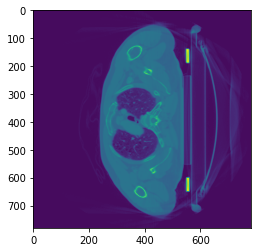

In [21]:
from matplotlib import pyplot as plt

plt.imshow(inputs[0,0,:,:,16])

# References

[1] Chen, Z., Li, C., He, J., Ye, J., Song, D., Wang, S., ... & Qiao, Y. (2021, September). A Novel Hybrid Convolutional Neural Network for Accurate Organ Segmentation in 3D Head and Neck CT Images. In International Conference on Medical Image Computing and Computer-Assisted Intervention (pp. 569-578). Springer, Cham.
[2] Wang, P., Chen, P., Yuan, Y., Liu, D., Huang, Z., Hou, X., & Cottrell, G. (2018, March). Understanding convolution for semantic segmentation. In 2018 IEEE winter conference on applications of computer vision (WACV) (pp. 1451-1460). Ieee.